# **Применение SDRE для управления в задаче хищник-жертва**

### Алексей Филаткин Б03-904

Красный плодовый клещ (Panonychus ulmi) является одним из самых распространённых вредителей на яблочных плантациях. Для борьбы с ним используют паразитиморфных клещей вида Neoseiulus californicus.

Взаимодействие двух видов типа хищник-жертва описывается моделью Лотки-Вольтерра:
 \begin{cases}
   \dot x(t) = x(a - bx - cy)\\
   \dot y(t) = y(- d + fx)\\
   x(0) = 5 \\
   y(0) = 0.1
 \end{cases}
 где a - коэффициент рождаемости жертв, b - коэффициент, учитывающий огранниченость еды жертв, c - коэффициент убийства жертв при встрече с хищниками, d - смертность хищников, f - максимальная скорость увеличения популяции хищников, x и y число жертв и хищников на один яблоневый лист соответственно

Исходя из справочных данных и элементарных оценок, Tusset et al., 2016 [1] получили приближённые значения коэффициентов: 
$$ a = 0.113, b = 0.00113, c = 0.073, d = 0.05, f = 0.02$$
При этом учитывалось, что система должна приходить в устойчивое равновесие, чему из трёх возможных удовлетворяет лишь положение $x^{*} = 2.5 \text{клещей/лист}, y^{*} = 1.5247 \text{клещей/лист}$

In [1]:
# Подключение бибилиотек
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

In [2]:
# Задание коэффициентов
a = 0.113
b = 0.00113
c = 0.073
d = 0.05
f = 0.02

In [3]:
# Правая часть системы уравнений
def rhs(t, x):
    x_dot = np.zeros(2)
    x_dot[0] = x[0] * (a - b * x[0] - c * x[1])
    x_dot[1] = x[1] * (- d + f * x[0])
    return x_dot

In [4]:
# Задание начальных условий
x0 = np.array([5, 0.1])
# Задание сетки по времени
t0 = 0
tf = 3500
dt = 0.1
t_eval = np.arange(t0, tf, dt)
# Решение системы уравнений
solution = solve_ivp(lambda t, x: rhs(t, x), (t0, tf), x0, t_eval=t_eval)
# Сбор данных
P = solution.y[0]
N = solution.y[1]
t = solution.t

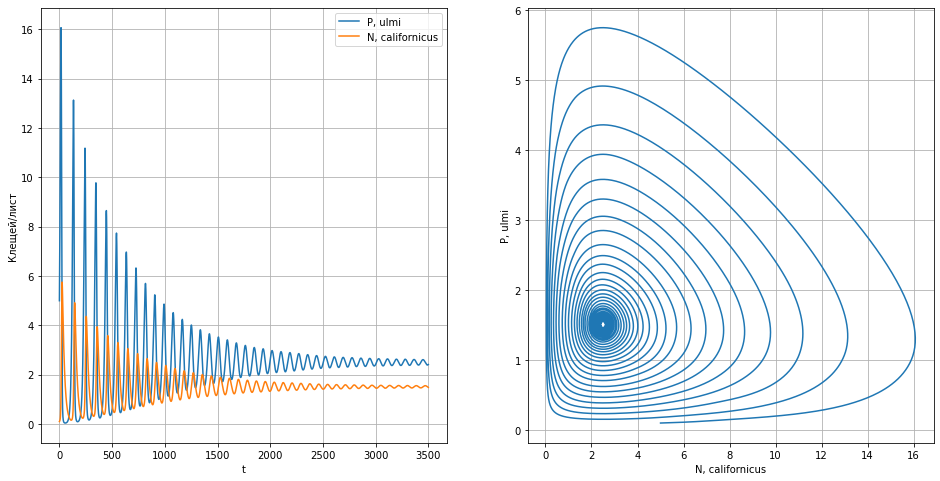

In [5]:
# Построение графиков
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, P, label='P, ulmi')
ax.plot(t, N, label='N, californicus')
ax.set_xlabel('t')
ax.set_ylabel('Клещей/лист')
ax.grid()
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(P, N)
ax.set_xlabel('N, californicus')
ax.set_ylabel('P, ulmi')
ax.grid()
plt.show()

Действительно, на фазовом портрете можно видеть устойчивый фокус в точке (2.5, 1.5). При этом на стабилизацию числа вредителей уходит ОГРОМНОЕ количество времени.

Таким образом, чтобы не разориться, придётся контролировать популяцию хищников. 

### **Использование линейно-квадратичного регулятора**
Задача управления: найти решение системы
\begin{equation}
  \frac{d Z}{dt} = A(Z) Z + B U\\
\end{equation}
минимизирующее функционал
\begin{equation}
  J = \frac{1}{2} \int \limits_0^{∞} (Z^{T} Q Z + U^T R U ) dt
\end{equation}
где $Z = \begin{bmatrix} x - x^{*} \\ y - y^{*} \end{bmatrix}$, $A(Z) = \begin{pmatrix} a - b (z_{1} + x^{*}) & -c (z_{1} + x^{*}) \\ f (z_{2} + y{*} ) & -d \end{pmatrix}$, $B(Z) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$
$Q = \begin{pmatrix} 0.001 & 0.001 \\ 0.001 & -0.02 \end{pmatrix}$, R = 1

Управление имеет вид:
\begin{equation}
 U = -K(Z) Z = -R^{-1} B^{T} P Z
\end{equation}
где P - решение стационарного уравнения Риккати, зависящего от **состояния**:
\begin{equation}
P A + A^T P - P B R^{-1} B^{T} P + Q = 0
\end{equation} 

In [6]:
# Задание необходимого равновесного положения и постоянных матриц
x1 = np.array([2.5, 1.5247])
B = np.array([[0], [1]])
Q = np.array([[0.001, 0.001], [0.001, 0.02]])
R = np.eye(1)

In [7]:
# Правая часть системы уравнений
def rhs(t, z, calcCtrl):
    # Расчёт матрицы А, зависящей от текущего состоянии
    A = np.zeros((2, 2))
    A[0, 0] = a - b * (z[0] + x1[0])
    A[0, 1] = - c * (z[0] + x1[0])
    A[1, 0] = f * (z[1] + x1[1])
    A[1, 1] = -d
    # Решение матричного стационарного уравнения Риккати
    P = solve_continuous_are(A, B, Q, R)
    # Расчёт управления
    u = - np.linalg.inv(R).dot(B.transpose().dot(P.dot(z)))
    if calcCtrl:
      return u
    z_dot = np.dot(A, z) + np.dot(B, u)
    return z_dot

In [8]:
# Задание начальных условий
x0 = np.array([5, 0.1])
z0 = x0 - x1
# Задание сетки по времени
t0 = 0
tf = 100
dt = 0.1
t_eval = np.arange(t0, tf, dt)
# Решение системы уравнений
solution = solve_ivp(lambda t, z: rhs(t, z, False), (t0, tf), z0, t_eval=t_eval)
# Сбор данных
P = solution.y[0] + x1[0]
N = solution.y[1] + x1[1]
t = solution.t
control = np.zeros(len(P))
for i in range(len(P)):
    control[i] = rhs(t[i], [P[i] - x1[0], N[i] - x1[1]], True)

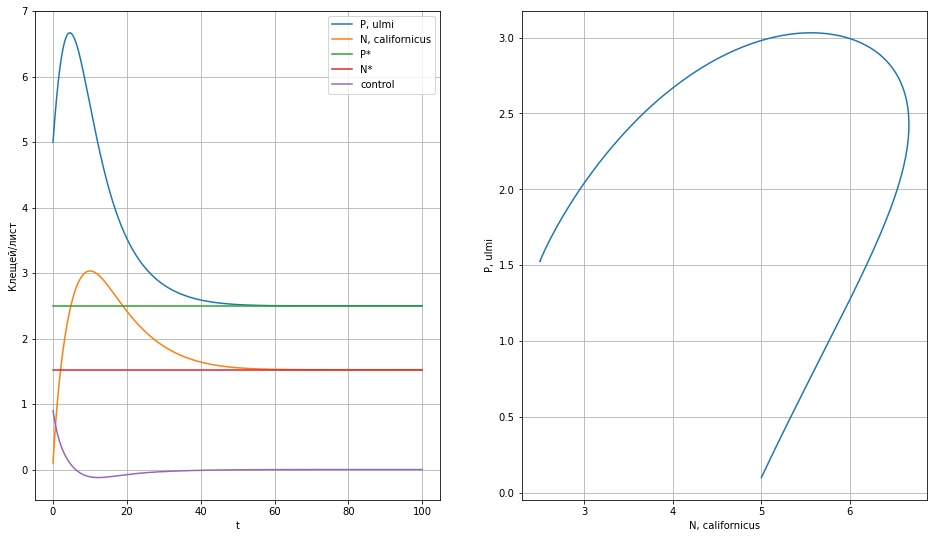

In [9]:
# Построение графиков
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, P, label='P, ulmi')
ax.plot(t, N, label='N, californicus')
ax.plot(t, x1[0] * np.ones(len(P)), label='P*')
ax.plot(t, x1[1] * np.ones(len(N)), label='N*')
ax.plot(t, control, label='control')
ax.set_xlabel('t')
ax.set_ylabel('Клещей/лист')
ax.grid()
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(P, N)
ax.set_xlabel('N, californicus')
ax.set_ylabel('P, ulmi')
ax.grid()
plt.show()

Примерно за 50 дней удаётся стабилизироваться, что намного лучше неконтролируемого размножения хищников(при этом управлять системой можно пересать раньше - на 30 дне). Однако, мы пойдём дальше.


### **Нелинейное наблюдение**
Если по какой-то причине невозможно наблюдать сразу за всеми популяциями(сложно, дорого и т.д.), попытаемся получить информацию о состоянии, например, по плотности жертв. В таком случае используется система наблюдения, которая по одной переменной восстанавливает исходное состояние системы:
 \begin{cases}
   \frac{d Z}{dt} = A(Z) Z + B \hat{U}\\
   Y = C Z\\
   \frac{d \hat{Z}}{dt} = A(\hat{Z}) \hat{Z} + B \hat{U} + K C (Z - \hat{Z})\\
 \end{cases}
где $C = \begin{pmatrix} 1 & 0\end{pmatrix}$, $\hat{Z} = \begin{bmatrix} \hat{x} - x^{*} \\ \hat{y} - y^{*} \end{bmatrix}$

Минимизируется функционал
\begin{equation}
  J = \frac{1}{2} \int \limits_0^{∞} (\hat{Z}^{T} \hat{Q} \hat{Z} + \hat{U}^T \hat{R} \hat{U} ) dt
\end{equation}
где $\hat{Q} = \begin{pmatrix} 1 & 0 \\ 0 & 10 \end{pmatrix}, \hat{R} = 0.01$

Тогда управление принимает вид
\begin{equation}
 U = -R^{-1} B^{T} P(\hat{Z}) \hat{Z}
\end{equation}
а весовая матрица вычисляется следующим образом:
\begin{equation}
 K = \hat{P}(\hat{Z}) C \hat{R}^{-1}
\end{equation}
где $\hat{P}$ - решение дуального уравнения Риккати ([2])
\begin{equation}
\hat{P} A^T(\hat{Z}) + A(\hat{Z}) \hat{P} - \hat{P} C^T \hat{R}^{-1} C \hat{P} + \hat{Q} = 0
\end{equation}
Начальные условия на систему наблюдения: 
\begin{cases}
   \hat{x}(0) = 3.5 \\
   \hat{y}(0) = 0.1
 \end{cases}

In [10]:
# Задание матриц
C = np.array([[1], [0]]).transpose()
Q_e = np.array([[1, 0], [0, 10]])
R_e = 0.01 * np.eye(1)

In [11]:
# Расчёт матрицы А
def get_A(z):
    A = np.zeros((2, 2))
    A[0, 0] = a - b * (z[0] + x1[0])
    A[0, 1] = - c * (z[0] + x1[0])
    A[1, 0] = f * (z[1] + x1[1])
    A[1, 1] = -d
    return A

# Правая часть системы уравнений
def rhs(t, X, calcCtrl):
    z = np.array([X[0], X[1]])
    z_e = np.array([X[2], X[3]])
    A = get_A(z)
    A_e = get_A(z_e)
    # Решение матричного стационарного уравнения Риккати и дуального уравнения Риккати
    P = solve_continuous_are(A_e, B, Q, R)
    P_e = solve_continuous_are(A_e.transpose(), C.transpose(), Q_e, R_e)
    # Расчёт управления
    u = - np.linalg.inv(R).dot(B.transpose().dot(P.dot(z_e)))
    if calcCtrl:
        return u
    K = P_e.dot(C.transpose().dot(np.linalg.inv(R_e)))
    z_dot = np.dot(A_e, z) + np.dot(B, u)
    z_e_dot = np.dot(A_e, z_e) + np.dot(B, u) + np.dot(K, C.dot(z - z_e))
    X_dot = np.concatenate((z_dot, z_e_dot))
    return X_dot


In [12]:
# Задание начальных условий
x0 = np.array([5, 0.1])
x0_e = np.array([3.5, 0.1])
z0 = x0 - x1
z0_e = x0_e - x1
initial = np.concatenate((z0, z0_e))
# Задание сетки по времени
t0 = 0
tf = 100
dt = 0.1
t_eval = np.arange(t0, tf, dt)
# Решение системы уравнений
solution = solve_ivp(lambda t, X: rhs(t, X, False), (t0, tf), initial, t_eval=t_eval)
# Сбор данных
P = solution.y[0] + x1[0]
N = solution.y[1] + x1[1]
P_e = solution.y[2] + x1[0]
N_e = solution.y[3] + x1[1]
t = solution.t
e1 = N - N_e
e2 = P - P_e

control = np.zeros(len(P))
for i in range(len(P)):
    control[i] = rhs(t[i], [P[i] - x1[0], N[i] - x1[1], P_e[i] - x1[0], N_e[i] - x1[1]], True)

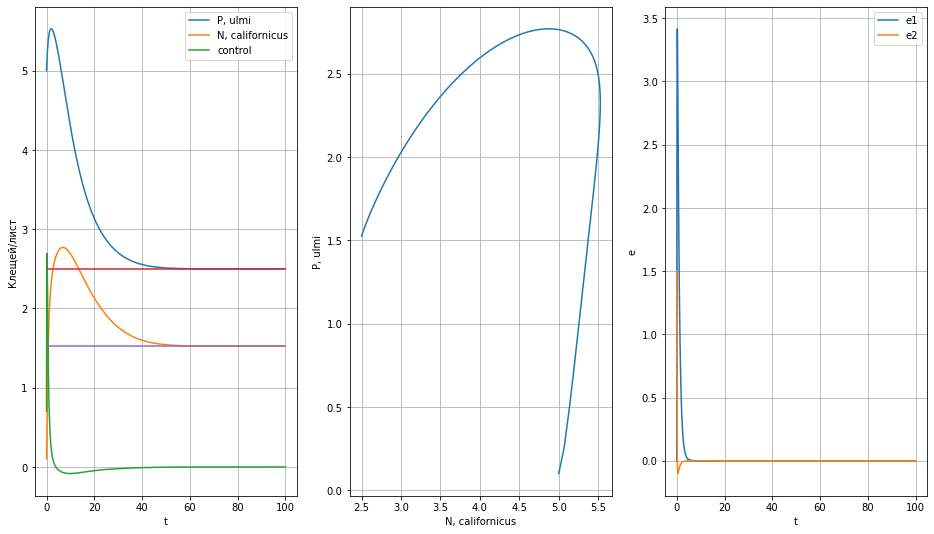

In [13]:
# Построение графиков
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(1, 3, 1)
ax.plot(t, P, label='P, ulmi')
ax.plot(t, N, label='N, californicus')
ax.plot(t, control, label='control')
ax.plot(t, x1[0] * np.ones(len(P)))
ax.plot(t, x1[1] * np.ones(len(N)))
ax.set_xlabel('t')
ax.set_ylabel('Клещей/лист')
ax.grid()
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(P, N)
ax.set_xlabel('N, californicus')
ax.set_ylabel('P, ulmi')
ax.grid()

ax = fig.add_subplot(1, 3, 3)
ax.plot(t, e1, label='e1')
ax.plot(t, e2, label='e2')
ax.set_xlabel('t')
ax.set_ylabel('e')
ax.grid()
ax.legend()
plt.show()

Как видно, разница между динамической и статической моделью $e = Z - \hat{Z}$ очень быстро сходится к нулю. Время установления равновесия такое же, как и при использовании SDRE без наблюдателя

### **Литература**
[1] https://www.worldscientific.com/doi/abs/10.1142/S0218339016500170

[2] https://link.springer.com/content/pdf/10.1007/s10589-007-9015-2.pdf